In [1]:
%load_ext autoreload
%autoreload 2

repbrep = '../../'
outdir = '../../figures/'
results_dir = '../../results'

## Accuracy Plots

In [ ]:
from plotting import plot_classification_accuracies, plot_segmentation_accuracies
import pandas as pd
import altair_saver
import os

segmentation_predictions = pd.read_parquet(os.path.join(repbrep, 'results/segmentation_predictions.parquet'))
classification_predictions = pd.read_parquet(os.path.join(repbrep, 'results/classification_predictions.parquet'))

f360_accuracy_plot = plot_segmentation_accuracies(segmentation_predictions,  'Fusion360Seg', 'macro', title='Fusion 360 Segmentation')
mfcad_accuracy_plot = plot_segmentation_accuracies(segmentation_predictions,  'MFCAD', 'macro', title='MFCAD Segmentation')

classification_predictions = classification_predictions[(classification_predictions.ommitted == False)] # UV-Net Cannot distinguish classes 14 and 22 -- they are nearly identical

fabwave_accuracy_plot = plot_classification_accuracies(classification_predictions, 'FabWave', title='FabWave Classification')

os.makedirs(outdir, exist_ok=True)
altair_saver.save(f360_accuracy_plot, os.path.join(outdir, 'f360-accuracy-plot.pdf'))
altair_saver.save(mfcad_accuracy_plot, os.path.join(outdir, 'mfcad-accuracy-plot.pdf'))
altair_saver.save(fabwave_accuracy_plot, os.path.join(outdir, 'fabwave-accuracy-plot.pdf'))

## Dataset Gallery

In [ ]:
import torch
import numpy as np
from rendering import find_best_angle_from_part, render_part, render_mesh
from tqdm import tqdm
from render_shape import preds_to_mesh
from zipfile import ZipFile
import json
from automate import Part
from train_latent_space import BRepFaceAutoencoder
from matplotlib import pyplot as plt
import os


datasets = os.path.join(repbrep, 'datasets')
model_dir = os.path.join(repbrep, 'models', 'BRepFaceAutoencoder_64_1024_4')
results_dir = os.path.join(repbrep, 'results')

f360seg_index_path = os.path.join(datasets, 'fusion360seg.json')
f360seg_zip_path = os.path.join(datasets, 'fusion360seg.zip')
model_checkpoint_path = os.path.join(model_dir, 'BRepFaceAutoencoder_64_1024_4.ckpt')
computed_f360seg_codes_path = os.path.join(model_dir, 'fusion360seg_coded.pt')
render_losses_path = os.path.join(results_dir, 'f360_render_test_losses.pt')
figure_out_path = os.path.join(outdir, 'datasetgallery.png')

train_poses_path = os.path.join(datasets, 'f360seg_test_poses.npy')
train_zooms_path = os.path.join(datasets, 'f360seg_test_zooms.npy')

rows = 4
cols = 6
size = 5

grid_density = 100
seed = 42


with open(f360seg_index_path,'r') as f:
    index = json.load(f)
data =  ZipFile(f360seg_zip_path,'r')
parts_list = [index['template'].format(*x) for x in index['test']]

np.random.seed(42)
to_render_idx = np.random.choice(np.arange(len(parts_list)), rows*cols, replace=False)

gts = []

poses = np.load(train_poses_path)
zooms = np.load(train_zooms_path)



for k in tqdm(range(rows*cols)):
    i = to_render_idx[k]
    path = parts_list[k]
    part = Part(data.open(path).read().decode('utf-8'))
    pose = poses[i]
    zoom = zooms[i]
    ground_truth = render_part(part, pose, zoom)
    gts.append(ground_truth)

M = rows*cols
s = size
fig, axes = plt.subplots(int(M/cols), cols, figsize=(cols*s, s*int(M/cols)),gridspec_kw = {'wspace':0, 'hspace':0}, dpi=300)
for i in range(M):
    row = int(i / cols)
    col = i % cols
    axes[row,col].imshow(gts[i])
    axes[row,col].axis('off')
fig.savefig(figure_out_path)

In [ ]:
len(index['train'])+len(index['test'])

## Reconstruction Gallery

In [ ]:
import torch
import numpy as np
from rendering import find_best_angle_from_part, render_part, render_mesh
from tqdm.notebook import tqdm
from render_shape import preds_to_mesh
from zipfile import ZipFile
import json
from automate import Part
from train_latent_space import BRepFaceAutoencoder
from matplotlib import pyplot as plt
import os


datasets = os.path.join(repbrep, 'datasets')
model_dir = os.path.join(repbrep, 'models', 'BRepFaceAutoencoder_64_1024_4')
results_dir = os.path.join(repbrep, 'results')

f360seg_index_path = os.path.join(datasets, 'fusion360seg.json')
f360seg_zip_path = os.path.join(datasets, 'fusion360seg.zip')
model_checkpoint_path = os.path.join(model_dir, 'BRepFaceAutoencoder_64_1024_4.ckpt')
computed_f360seg_codes_path = os.path.join(model_dir, 'fusion360seg_coded.pt')
render_losses_path = os.path.join(results_dir, 'f360_render_test_losses.pt')
figure_out_path = os.path.join(outdir, 'reconstructions.png')

test_poses_path = os.path.join(datasets, 'f360seg_test_poses.npy')
test_zooms_path = os.path.join(datasets, 'f360seg_test_zooms.npy')

rows = 4
cols = 6
size = 5

grid_density = 100

force_rendering = True



testing_losses = torch.load(render_losses_path)
avg_losses = np.array([x[0].item() for x in testing_losses])
part_sizes = np.array([x[1] for x in testing_losses])
total_losses = avg_losses * part_sizes
avg_sorted = sorted(enumerate(zip(avg_losses, part_sizes, total_losses)),key=lambda x: x[1][0])
total_sorted = sorted(enumerate(zip(avg_losses, part_sizes, total_losses)),key=lambda x: x[1][2])
total_filtered = [x for x in total_sorted if x[1][1] > 20]


render_results_path = os.path.join(outdir, 'tmp', 'render_results.pt')

recompute_renderings = True
if os.path.exists(render_results_path) and not force_rendering:
    render_results = torch.load(render_results_path)
    renders = render_results['renders']
    gts = render_results['gts']
    if len(renders) >= rows*cols:
        recompute_renderings = False

if recompute_renderings:
    with open(f360seg_index_path,'r') as f:
        index = json.load(f)
    data =  ZipFile(f360seg_zip_path,'r')
    parts_list = [index['template'].format(*x) for x in index['test']]

    model = BRepFaceAutoencoder(64,1024,4)
    ckpt = torch.load(model_checkpoint_path)
    model.load_state_dict(ckpt['state_dict'])

    def predict(face_codes, model, N=grid_density):
        n_faces = face_codes.shape[0]
        line = torch.linspace(-0.1,1.1,N)
        grid = torch.cartesian_prod(line, line)
        grids = grid.repeat(n_faces,1)
        indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)
        with torch.no_grad():
            indexed_codes = face_codes[indices]
            uv_codes = torch.cat([grids, indexed_codes],dim=1)
            preds = model.decoder(uv_codes)
        return preds

    codes = torch.load(computed_f360seg_codes_path)

    gts = []
    renders = []

    poses = np.load(test_poses_path)
    zooms = np.load(test_zooms_path)

    for k in tqdm(range(rows*cols)):
        i = total_filtered[k][0]
        N = grid_density
        preds = predict(codes[parts_list[i]]['x'], model, N)
        V, F, C = preds_to_mesh(preds, N)
        part = Part(data.open(parts_list[i]).read().decode('utf-8'))
        pose = poses[i]
        zoom = zooms[i]
        ground_truth = render_part(part, pose, zoom)
        rendering = render_mesh(V,F,C,pose,zoom)
        gts.append(ground_truth)
        renders.append(rendering)

    render_results = {'gts':gts,'renders':renders}
    torch.save(render_results, render_results_path)



M = rows*cols
s = size
fig, axes = plt.subplots(int(M/cols), cols*2, figsize=(2*cols*s, s*int(M/cols)),gridspec_kw = {'wspace':0, 'hspace':0}, dpi=300)
for i in range(M):
    row = int(i / cols)
    col = i % cols
    axes[row,2*col].imshow(gts[i])
    axes[row,2*col].axis('off')
    axes[row,2*col+1].imshow(renders[i])
    axes[row,2*col+1].axis('off')
fig.savefig(figure_out_path)

In [ ]:
# Version Using New Rendering Code
# Problems:
#  - normalizing parts and reconstructions separately makes them different sizes
#    - solution: have a non-normalized version of camera param finding

import torch
from tqdm import tqdm
from train_latent_space import BRepFaceAutoencoder
from rendering import render_segmented_mesh, get_camera_angle, grid_images, RendererParams
from render_shape import preds_to_mesh
from zipfile import ZipFile
import json
from automate import Part
import numpy as np
import os
from PIL import Image

datasets = os.path.join(repbrep, 'datasets')
model_dir = os.path.join(repbrep, 'models', 'BRepFaceAutoencoder_64_1024_4')

f360seg_index_path = os.path.join(datasets, 'fusion360seg.json')
f360seg_zip_path = os.path.join(datasets, 'fusion360seg.zip')
model_checkpoint_path = os.path.join(model_dir, 'BRepFaceAutoencoder_64_1024_4.ckpt')
computed_f360seg_codes_path = os.path.join(model_dir, 'fusion360seg_coded.pt')
render_losses_path = os.path.join(results_dir, 'f360_render_test_losses.pt')
figure_out_path = os.path.join(outdir,'reconstructions_transparent.png')

grid_density = 100 # Point Sampling Density Per Face

rows = 4
cols = 6
imsize=800

print('Loading and Filtering Losses')
testing_losses = torch.load(render_losses_path)
avg_losses = np.array([x[0].item() for x in testing_losses])
part_sizes = np.array([x[1] for x in testing_losses])
total_losses = avg_losses * part_sizes
avg_sorted = sorted(enumerate(zip(avg_losses, part_sizes, total_losses)),key=lambda x: x[1][0])
total_sorted = sorted(enumerate(zip(avg_losses, part_sizes, total_losses)),key=lambda x: x[1][2])
total_filtered = [x for x in total_sorted if x[1][1] > 20]

print('Loading Dataset')
with open(f360seg_index_path,'r') as f:
    index = json.load(f)
data =  ZipFile(f360seg_zip_path,'r')
parts_list = [index['template'].format(*x) for x in index['test']]

print('Loading Model')
model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])

def predict(face_codes, model, N=grid_density):
    n_faces = face_codes.shape[0]
    line = torch.linspace(-0.1,1.1,N)
    grid = torch.cartesian_prod(line, line)
    grids = grid.repeat(n_faces,1)
    indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)
    with torch.no_grad():
        indexed_codes = face_codes[indices]
        uv_codes = torch.cat([grids, indexed_codes],dim=1)
        preds = model.decoder(uv_codes)
    return preds

codes = torch.load(computed_f360seg_codes_path)

gts = []
renders = []

renderer = None

for k in tqdm(range(rows*cols), 'Predicting and Rendering'):
    i = total_filtered[k][0]
    N = grid_density
    preds = predict(codes[parts_list[i]]['x'], model, N)
    V, F, C = preds_to_mesh(preds, N)
    part = Part(data.open(parts_list[i]).read().decode('utf-8'))
    
    camera_params = get_camera_angle(
        part.mesh.V, 
        part.mesh.F, 
        part.mesh_topology.face_to_topology,
        optimize='seg'
    )

    gt_im = render_segmented_mesh(
        part.mesh.V, part.mesh.F, part.mesh_topology.face_to_topology,
        camera_params=camera_params,
        render_params=RendererParams(imsize,imsize)
        )
    
    recon_im = render_segmented_mesh(
        V, F, C, camera_params=camera_params,
        render_params=RendererParams(imsize,imsize)
    )

    gts.append(gt_im)
    renders.append(recon_im)

image_rows = []
for r in range(rows):
    curr_row = []
    for c in range(cols):
        idx = r*cols+c
        gt = gts[idx]
        recon = renders[idx]
        curr_row.append(gt)
        curr_row.append(recon)
    curr_row = np.stack(curr_row)
    image_rows.append(curr_row)
image_rows = np.stack(image_rows)

image_grid = grid_images(image_rows)

Image.fromarray(image_grid.astype(np.uint8)).save(figure_out_path)

## Greyscale Reconstruction for Overview

In [ ]:
# Version Using New Rendering Code
# Problems:
#  - normalizing parts and reconstructions separately makes them different sizes
#    - solution: have a non-normalized version of camera param finding

import torch
from tqdm import tqdm
from train_latent_space import BRepFaceAutoencoder
from rendering import render_segmented_mesh, get_camera_angle, grid_images, RendererParams
from render_shape import preds_to_mesh
from zipfile import ZipFile
import json
from automate import Part, PartOptions
import numpy as np
import os
from PIL import Image

datasets = os.path.join(repbrep, 'datasets')
model_dir = os.path.join(repbrep, 'models', 'BRepFaceAutoencoder_64_1024_4')

f360seg_index_path = os.path.join(datasets, 'fusion360seg.json')
f360seg_zip_path = os.path.join(datasets, 'fusion360seg.zip')
model_checkpoint_path = os.path.join(model_dir, 'BRepFaceAutoencoder_64_1024_4.ckpt')
computed_f360seg_codes_path = os.path.join(model_dir, 'fusion360seg_coded.pt')
render_losses_path = os.path.join(results_dir, 'f360_render_test_losses.pt')
figure_out_path = os.path.join(outdir,'greyscale_reconstructions.png')

grid_density = 100 # Point Sampling Density Per Face

rows = 4
cols = 6
imsize=800

print('Loading and Filtering Losses')
testing_losses = torch.load(render_losses_path)
avg_losses = np.array([x[0].item() for x in testing_losses])
part_sizes = np.array([x[1] for x in testing_losses])
total_losses = avg_losses * part_sizes
avg_sorted = sorted(enumerate(zip(avg_losses, part_sizes, total_losses)),key=lambda x: x[1][0])
total_sorted = sorted(enumerate(zip(avg_losses, part_sizes, total_losses)),key=lambda x: x[1][2])
total_filtered = [x for x in total_sorted if x[1][1] > 20]

print('Loading Dataset')
with open(f360seg_index_path,'r') as f:
    index = json.load(f)
data =  ZipFile(f360seg_zip_path,'r')
parts_list = [index['template'].format(*x) for x in index['test']]

print('Loading Model')
model = BRepFaceAutoencoder(64,1024,4)
ckpt = torch.load(model_checkpoint_path)
model.load_state_dict(ckpt['state_dict'])

def predict(face_codes, model, N=grid_density):
    n_faces = face_codes.shape[0]
    line = torch.linspace(-0.1,1.1,N)
    grid = torch.cartesian_prod(line, line)
    grids = grid.repeat(n_faces,1)
    indices = torch.arange(n_faces).repeat_interleave(N*N, dim=0)
    with torch.no_grad():
        indexed_codes = face_codes[indices]
        uv_codes = torch.cat([grids, indexed_codes],dim=1)
        preds = model.decoder(uv_codes)
    return preds

codes = torch.load(computed_f360seg_codes_path)

gts = []
renders = []

renderer = None

options = PartOptions()
options.set_quality = True
options.quality = 0.001

for k in tqdm(range(rows*cols), 'Predicting and Rendering'):
    i = total_filtered[k][0]
    N = grid_density
    preds = predict(codes[parts_list[i]]['x'], model, N)
    V, F, C = preds_to_mesh(preds, N)
    part = Part(data.open(parts_list[i]).read().decode('utf-8'), options)
    
    camera_params = get_camera_angle(
        part.mesh.V, 
        part.mesh.F, 
        part.mesh_topology.face_to_topology,
        optimize='seg'
    )

    n_faces = part.mesh_topology.face_to_topology.max() + 1

    face_colors = np.ones((n_faces,3)).astype(int)*150

    gt_im = render_segmented_mesh(
        part.mesh.V, part.mesh.F, part.mesh_topology.face_to_topology, face_colors,
        camera_params=camera_params,
        render_params=RendererParams(imsize,imsize)
        )
    
    recon_im = render_segmented_mesh(
        V, F, C, face_colors, camera_params=camera_params,
        render_params=RendererParams(imsize,imsize)
    )

    gts.append(gt_im)
    renders.append(recon_im)

image_rows = []
for r in range(rows):
    curr_row = []
    for c in range(cols):
        idx = r*cols+c
        gt = gts[idx]
        recon = renders[idx]
        curr_row.append(gt)
        curr_row.append(recon)
    curr_row = np.stack(curr_row)
    image_rows.append(curr_row)
image_rows = np.stack(image_rows)

image_grid = grid_images(image_rows)

Image.fromarray(image_grid.astype(np.uint8)).save(figure_out_path)

## Limitations Plot

In [ ]:
import altair as alt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import altair_saver

accs = pd.read_parquet(os.path.join(results_dir, 'fusion360seg_reconstruction_vs_accuracy.parquet'))
accs['one'] = 1
iscorr = np.vectorize(lambda x: 'correct' if x == 1 else 'incorrect')
accs['correct'] = iscorr(accs.label)
accs['logmse'] = np.log(accs.mse)


alt.data_transformers.disable_max_rows()

lim_plot = alt.Chart(accs[accs.mse < 1]).mark_bar().encode(
    x=alt.X('logmse',bin=alt.Bin(maxbins=50)),
    y=alt.Y('sum(one)', stack='normalize', axis=alt.Axis(format='%')),
    color=alt.Color('label:N')
).facet(row='train_size')

altair_saver.save(lim_plot, os.path.join(outdir, 'limitations.pdf'))


## Classification Comparisons

In [ ]:
from plotting import render_segmentation_comparisons_newplotting

f360_comparisons = render_segmentation_comparisons_newplotting(root=repbrep)
Image.fromarray(f360_comparisons.astype(np.uint8)).save(os.path.join(outdir, 'f360seg-comparisons.png'))

In [ ]:
from plotting import render_segmentation_comparisons_newplotting


mfcad_comparisons = render_segmentation_comparisons_newplotting(
    root=repbrep,
    dataset_name='mfcad',
    camera_name='mfcad',
    dataset='MFCAD',
    max_labels=16
)
Image.fromarray(mfcad_comparisons.astype(np.uint8)).save(os.path.join(outdir, 'mfcad-comparison.png'))

## Segmentation Gallery

In [ ]:
import numpy as np
from rendering import render_segmented_mesh, grid_images, RendererParams
from util import ZippedDataset

# Counted from image
rowcol = np.array([[0,7],
[1,11],
[2,9],
[4,3],
[7,18],
[10,2],
[13,10],
[15,14],
[18,3],
[18,15]])
test_indices = rowcol.dot(np.array([[20],[1]])).flatten()

ds = ZippedDataset(os.path.join(repbrep, 'datasets', 'fusion360seg'))

paths = [ds.index['template'].format(*ds.index['test'][i]) for i in test_indices]
parts = [Part(ds.zip.open(p,'r').read().decode('utf-8')) for p in paths]
seg_preds = pd.read_parquet(os.path.join(results_dir, 'segmentation_predictions.parquet'))

seg_preds = seg_preds[
    (seg_preds.dataset == 'Fusion360Seg') &
    (seg_preds.model == 'Ours') &
    (seg_preds.seed == 0) &
    (seg_preds.train_size == 23266)
]

preds_and_labels = seg_preds.sort_values(['test_idx','face_idx']).groupby('test_idx').agg({'label':list,'prediction':list}).reset_index()

preds = preds_and_labels.prediction.values[test_indices]
labels = preds_and_labels.label.values[test_indices]

renders = []
for part,label,pred in zip(parts,labels,preds):
    V = part.mesh.V
    F = part.mesh.F
    F_id = part.mesh_topology.face_to_topology
    l = np.array(label)
    p = np.array(pred)
    pred_im = render_segmented_mesh(V,F,F_id,p,render_params=RendererParams(800,800),camera_opt='seg')
    label_im = render_segmented_mesh(V,F,F_id,l,render_params=RendererParams(800,800),camera_opt='seg')
    renders.append(grid_images(np.stack([np.stack([label_im, pred_im])])))
image_grid = grid_images(np.stack(renders).reshape((5,2,800,1600,4)))
Image.fromarray(image_grid.astype(np.uint8)).save(os.path.join(outdir, 'segmentation_gallery.png'))

## Dataset Gallery

## BRep Hierarchy

In [ ]:
from automate import Part
from rendering import render_segmented_mesh, RendererParams
from util import arr2im

part = Part(os.path.join(repbrep, 'datasets', 'figure_parts', 'philipsbolt.step'))
V = part.mesh.V
F = part.mesh.F
F_id = part.mesh_topology.face_to_topology

renders = []
colors = np.stack([np.array([50,50,50,50])]*len(F_id))
renders.append(np.stack([render_segmented_mesh(V,F,F_id,colors,transparent_bg=False)]))
for i in tqdm(range(5)):
    colors = np.stack([np.array([50,50,50,50])]*len(F_id))
    colors[i] = [250,50,50,255]
    renders.append(np.stack([render_segmented_mesh(V,F,F_id,colors,transparent_bg=False)]))
arr2im(grid_images(np.stack(renders))).save(os.path.join(outdir, 'transparent_bolts.png'))

## Time Comparisons

In [ ]:
import pandas as pd
import altair as alt
import altair_saver

edf = pd.read_parquet(os.path.join(results_dir, 'tf_events.parquet'))

fv_edf = edf[
    edf.metric.str.contains('val') & 
    edf.metric.str.contains('loss') & 
    (~edf.metric.str.contains('step')) &
    (edf.dataset == 'f360seg')]

def get_stop_times(x):
    min_time = x.rel_time.values[x.value.values.argmin()]
    max_time = x.rel_time.values[x.value.values.argmax()]
    return pd.Series([min_time, max_time], index=['min_time','max_time'])
stopping_times = fv_edf.groupby(
    ['model','train_size','seed','metric']
    ).apply(get_stop_times).reset_index()

model_names = {
    'ours':'Ours',
    'uvnet':'UV-Net',
    'brepnet':'BRepNet'
}
rename_models = np.vectorize(lambda x: model_names[x])
stopping_times.model = rename_models(stopping_times.model)

stopping_times.min_time = stopping_times.min_time / 60

line = alt.Chart(stopping_times)\
    .mark_line()\
    .encode(
        x=alt.X('train_size', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Set Size')),
        y=alt.Y('mean(min_time)', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Time (minutes)')),
        color=alt.Color('model',sort=['Ours','UV-Net','BRepNet'],legend=alt.Legend(title='Model'))
    )
band = alt.Chart(stopping_times).mark_errorband(extent='ci').encode(
        x=alt.X('train_size', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Set Size')),
        y=alt.Y('min_time', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Time (minutes)')),
        color=alt.Color('model',sort=['Ours','UV-Net','BRepNet'],legend=alt.Legend(title='Model'))
    )
chart = (band + line).properties(title='Fusion 360 Segmentation Training Time vs Training Size')

altair_saver.save(chart, os.path.join(outdir, 'f360seg-time.pdf'))

In [ ]:
import pandas as pd
import altair as alt
import numpy as np
import altair_saver

edf = pd.read_parquet(os.path.join(results_dir, 'tf_events.parquet'))

fv_edf = edf[
    edf.metric.str.contains('val') & 
    edf.metric.str.contains('loss') & 
    (~edf.metric.str.contains('step')) &
    (edf.dataset == 'fabwave')]

def get_stop_times(x):
    min_time = x.rel_time.values[x.value.values.argmin()]
    max_time = x.rel_time.values[x.value.values.argmax()]
    return pd.Series([min_time, max_time], index=['min_time','max_time'])
stopping_times = fv_edf.groupby(
    ['model','train_size','seed','metric']
    ).apply(get_stop_times).reset_index()

model_names = {
    'ours':'Ours',
    'uvnet':'UV-Net',
    'brepnet':'BRepNet'
}
rename_models = np.vectorize(lambda x: model_names[x])
stopping_times.model = rename_models(stopping_times.model)

stopping_times.min_time = stopping_times.min_time / 60

line = alt.Chart(stopping_times)\
    .mark_line()\
    .encode(
        x=alt.X('train_size', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Set Size')),
        y=alt.Y('mean(min_time)', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Time (minutes)')),
        color=alt.Color('model',sort=['Ours','UV-Net','BRepNet'],legend=alt.Legend(title='Model'))
    )
band = alt.Chart(stopping_times).mark_errorband(extent='ci').encode(
        x=alt.X('train_size', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Set Size')),
        y=alt.Y('min_time', scale=alt.Scale(type='linear'),axis=alt.Axis(title='Training Time (minutes)')),
        color=alt.Color('model',sort=['Ours','UV-Net','BRepNet'],legend=alt.Legend(title='Model'))
    )
chart = (band + line).properties(title='Fusion 360 Segmentation Training Time vs Training Size')
chart
#altair_saver.save(chart, os.path.join(outdir, 'f360seg-time.pdf'))

## Clipping Plane

/home/ben/Documents/research/repbrep/hybridbrep/hybridbrep/hybridpart.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  data.edge_to_face = torch.tensor([part.face_to_edge[1], part.face_to_edge[0]]).long()


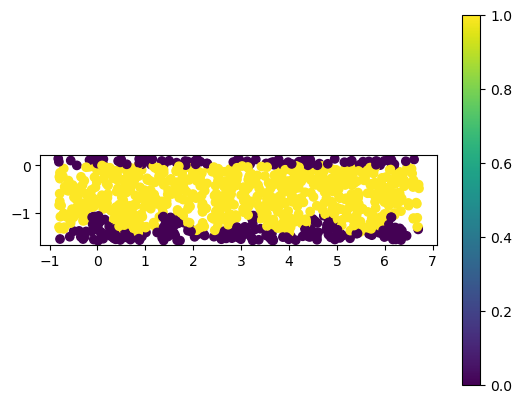

In [2]:
from hybridbrep import HPart
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
N = 1000#00
part_path = os.path.join(repbrep, 'datasets/figure_parts/philipsbolt.step')
data = HPart(part_path, N, N, True).data
u = data.surface_coords[0,:,0].numpy()
v = data.surface_coords[0,:,1].numpy()
#v = v.max() - v
m = data.surface_samples[0,:,-1].T.numpy()

((u_min, v_min), (u_max, v_max)) = data.surface_bounds[0].numpy()
u_prime = ((u *(u_max - u_min) + u_min) - (2*np.pi))
v_prime = (v * (v_max - v_min) + v_min)

plt.scatter(u_prime,v_prime,c=(m <= 0))
plt.colorbar()
plt.gca().set_aspect('equal')


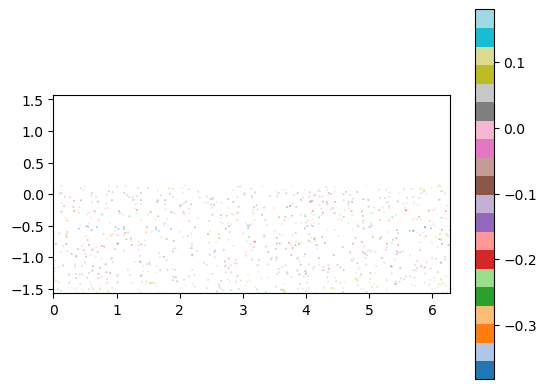

In [3]:
plt.scatter(u_prime,v_prime,c=(m),s=.03,cmap='tab20')
plt.colorbar()
plt.xlim(0,2*np.pi)
plt.ylim(-np.pi/2, np.pi/2)
plt.gca().set_aspect('equal')


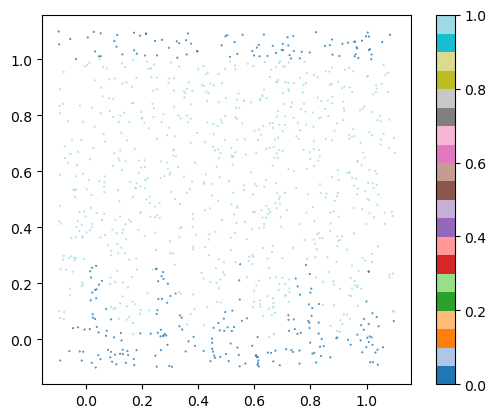

In [4]:
plt.scatter(u,v,c=(m<=0),s=.2, cmap='tab20')
plt.colorbar()
#plt.xlim(0,2*np.pi)
#plt.ylim(-np.pi/2, np.pi/2)
plt.gca().set_aspect('equal')

In [5]:
import meshplot as mp

In [6]:
xyz = data.surface_samples[0,:,:3].numpy()

In [7]:
mp.plot(xyz, c=m, shading={'point_size':.03})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-4.814565…

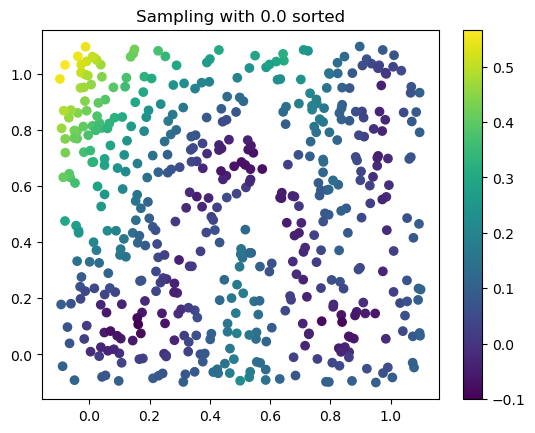

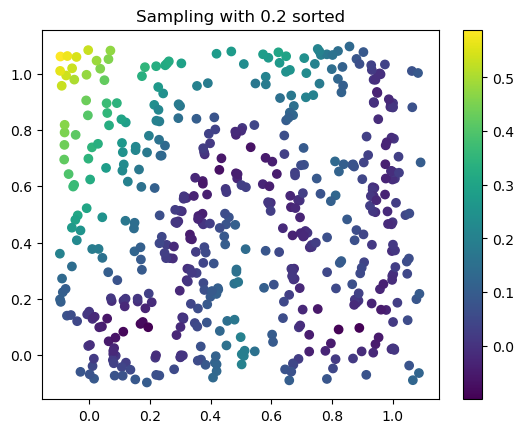

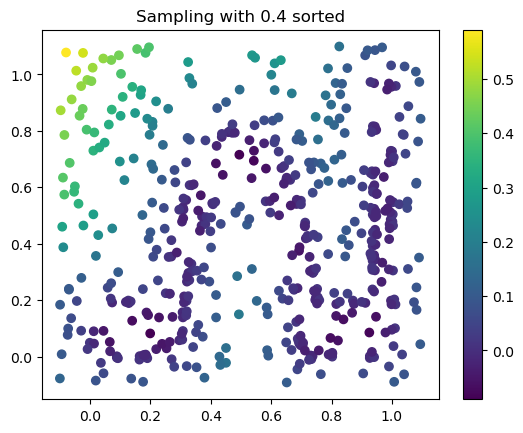

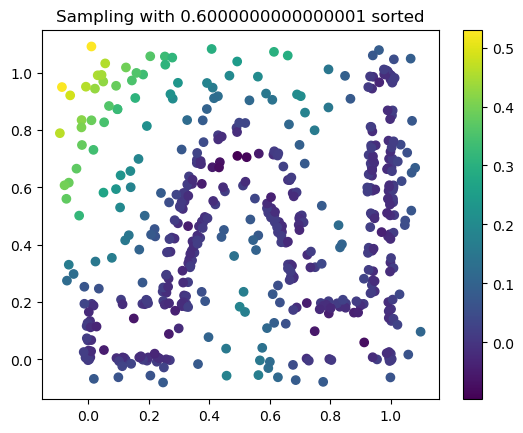

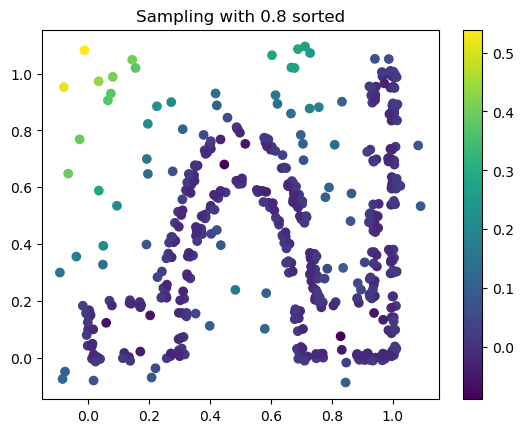

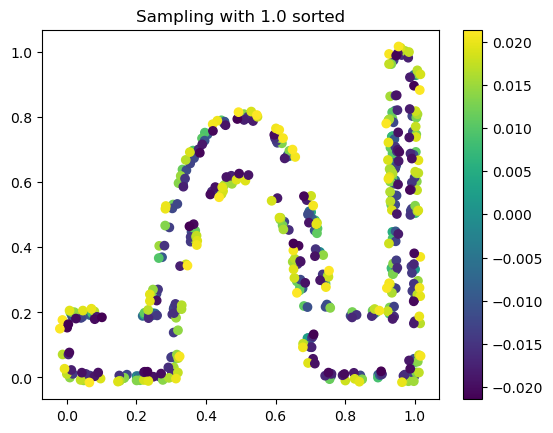

In [17]:
part_path_step = os.path.join(repbrep, 'datasets/frame_guide/fg1.step')
part_path_x_t = os.path.join(repbrep, 'datasets/frame_guide/fg1.x_t')

for frac in np.linspace(0,1.0,6):

    data = HPart(part_path_x_t, 500, 5000, True, frac).data

    u = data.surface_coords[11,:,0].numpy()
    v = data.surface_coords[11,:,1].numpy()
    #v = v.max() - v
    m = data.surface_samples[11,:,-1].T.numpy()

    plt.figure()
    plt.scatter(u,v,c=m)
    plt.colorbar()
    plt.title(f'Sampling with {frac} sorted')

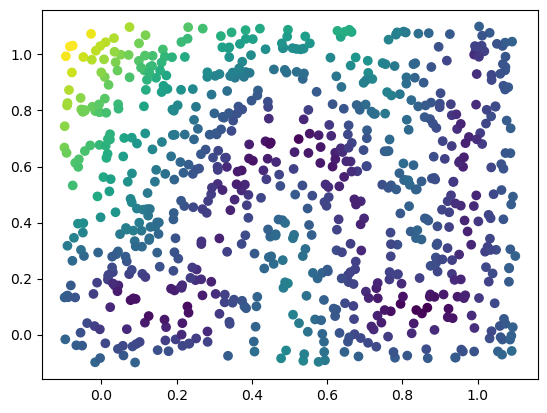

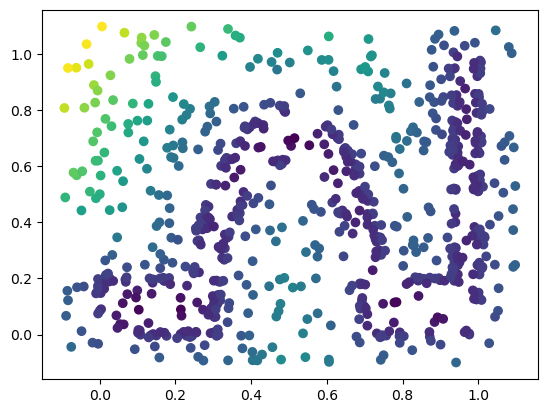